In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

test_transforms = train_transforms


# load MNIST dataset
trainset = datasets.MNIST(root='/home/sledge/datasets', train=True, download=True, transform= train_transforms)
testset = datasets.MNIST(root='/home/sledge/datasets', train=False, download=True, transform=test_transforms)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)

/home/sledge/miniconda3/envs/deep-learning/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


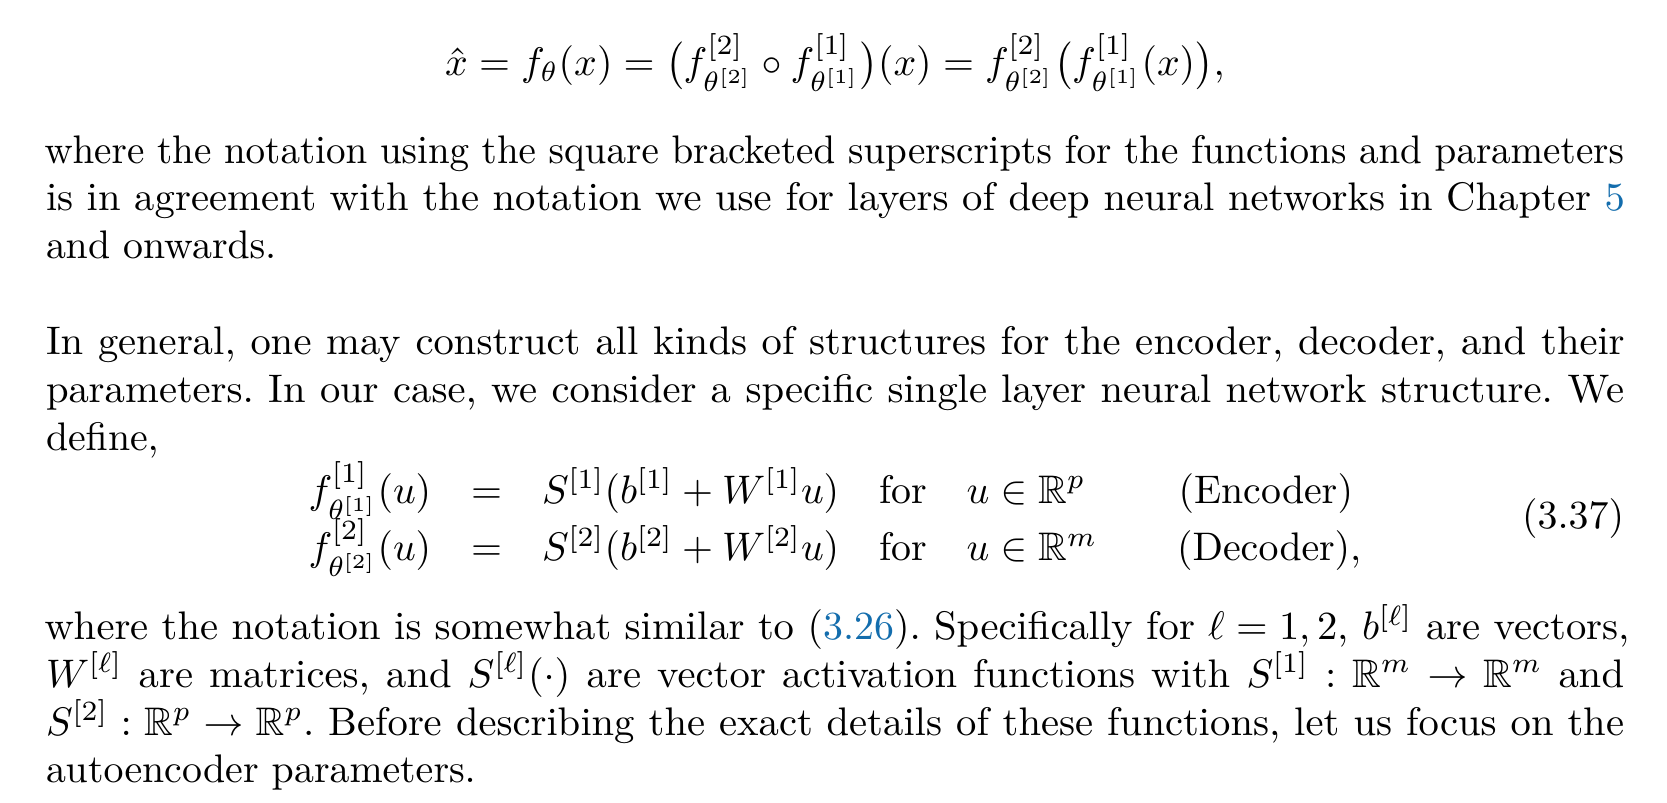

In [4]:
from tqdm import tqdm

class AbstractAutoencoder(nn.Module):
    def __init__(self):
        super(AbstractAutoencoder, self).__init__()
        self.encoder = None
        self.decoder = None

    def forward(self, X):
        return self.decode(self.encode(X))

    def encode(self, X):
        return self.encoder(X)

    def decode(self, X):
        return self.decoder(X)


In [5]:
class ShallowAutoencoder(AbstractAutoencoder):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid()
        )
    
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        
    def fit(self, train_loader, num_epochs, lr):
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=1e-5)
        for epoch in range(num_epochs):
            for data in (pbar := tqdm(train_loader, desc=f"ShallowAutoencoder fit epoch {epoch}")):
                inputs, _ = data
                inputs = inputs.to(device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, inputs)
                loss.backward()
                optimizer.step()
            pbar.set_postfix({"loss": loss.item()})

In [6]:
class DeepAutoencoder(AbstractAutoencoder):
    def __init__(self, dims: list[int]):
        super().__init__()

        # Encoder layers
        encoder_layers = nn.ModuleList()
        for ix in range(len(dims) - 1):
            encoder_layers.append(nn.Linear(dims[ix], dims[ix+1]))
            # No activation on the last layer
            if ix != len(dims) - 2:
                encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder layers
        decoder_layers = nn.ModuleList()
        for ix in range(len(dims) - 1, 0, -1):
            decoder_layers.append(nn.Linear(dims[ix], dims[ix-1]))
            # No activation on the last layer
            if ix != 1:
                decoder_layers.append(nn.ReLU())
            else:
                decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

        # Pretrain Layers
        self.pretrain_layers(train_loader, 1, 1e-3)

    def pretrain_layers(self, train_loader, num_epochs, lr):
        current_loader = train_loader
        for ix, layer in enumerate(self.encoder):
            if isinstance(layer, nn.Linear):
                print(f"Training layer {ix}")
                # Initialize the shallow version, with input_dim -> output_dim -> input_dim
                ae = ShallowAutoencoder(
                    self.encoder[ix].in_features,
                    self.encoder[ix].out_features,
                    self.encoder[ix].in_features).to(device)
                ae.fit(current_loader, num_epochs, lr)
                layer.weight.data = ae.encoder[0].weight.data.clone()
                layer.bias.data = ae.encoder[0].bias.data.clone()
                decoder_layer = self.decoder[-ix-2]
                decoder_layer.weight.data = ae.decoder[0].weight.data.clone()
                decoder_layer.bias.data = ae.decoder[0].bias.data.clone()

                # Update the current loader to use the output of the current layer
                def collate_fn(batch):
                    # batch is a tuple(list) of tuple, each tuple is (input, label)
                    inputs, labels = zip(*batch)
                    # inputs is now a list of tensors, labels is a list of integer
                    inputs = torch.stack(inputs).to(device)
                    labels = torch.tensor(labels).to(device)

                    with torch.no_grad():
                        inputs = ae.encode(inputs)

                    return inputs, labels

                ae.eval()
                current_loader = DataLoader(
                    train_loader.dataset,
                    batch_size=32,
                    shuffle=False,
                    num_workers=4,
                    pin_memory=True,
                    persistent_workers=True,
                    collate_fn=collate_fn
                )

In [7]:
from torchinfo import summary

# model = ShallowAutoencoder(input_dim=784, hidden_dim=30, output_dim=10)
model = DeepAutoencoder(dims=[784, 128, 64])
summary(model=model, input_size=(56, 1, 784))

Training layer 0


ShallowAutoencoder fit epoch 0: 100%|██████████| 1875/1875 [00:04<00:00, 388.27it/s]


Training layer 2


ShallowAutoencoder fit epoch 0:   0%|          | 0/1875 [00:00<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/sledge/miniconda3/envs/deep-learning/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/sledge/miniconda3/envs/deep-learning/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/tmp/ipykernel_32241/1480616074.py", line 50, in collate_fn
    inputs = torch.stack(inputs).to(device)
  File "/home/sledge/miniconda3/envs/deep-learning/lib/python3.10/site-packages/torch/cuda/__init__.py", line 305, in _lazy_init
    raise RuntimeError(
RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Test on grayscale image from MNIST.

In [8]:
from tqdm import tqdm

def train(model, loss_fn, optimizer, train_loader, test_loader, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        for images, _ in (pbar := tqdm(train_loader, desc=f"Train epoch {epoch}")):
            images = images.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_postfix({ 'loss': loss.item() })
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for images, _ in (pbar := tqdm(test_loader, desc=f"Test epoch {epoch}")):
                images = images.to(device)
                outputs = model(images)
                test_loss = loss_fn(outputs, images)
                pbar.set_postfix({ 'loss': test_loss.item() })

In [9]:
from torch.optim import Adam

loss_fn = nn.MSELoss()
# model = ShallowAutoencoder(input_dim=784, hidden_dim=30, output_dim=784).to(device)
model = DeepAutoencoder(dims=[784, 128, 64]).to(device)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train(model, loss_fn, optimizer, train_loader, test_loader, num_epochs=15)

Train:   0%|          | 0/1875 [00:00<?, ?it/s]

Test: 100%|██████████| 313/313 [00:01<00:00, 271.13it/s, loss=0.00506]


Reconstruction

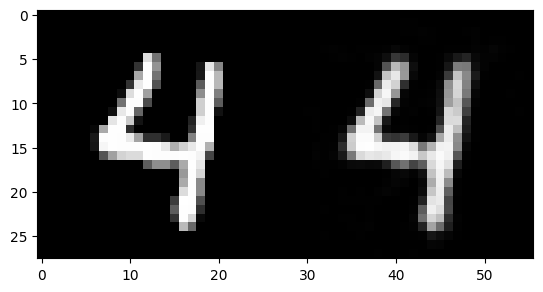

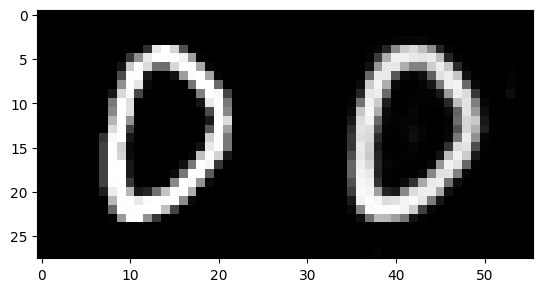

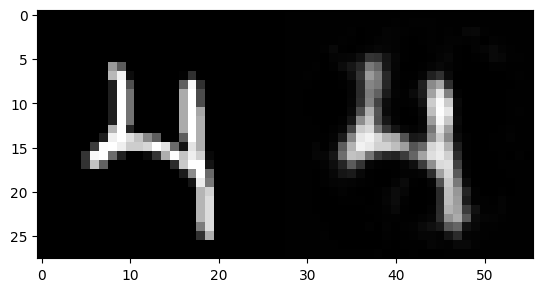

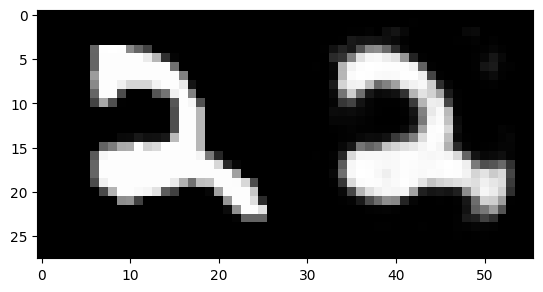

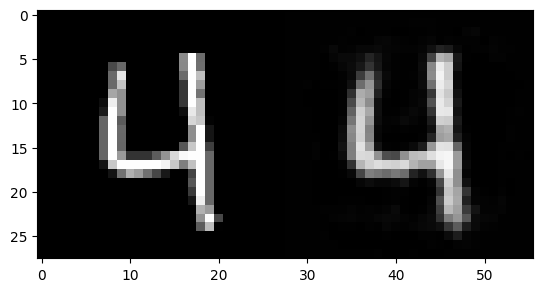

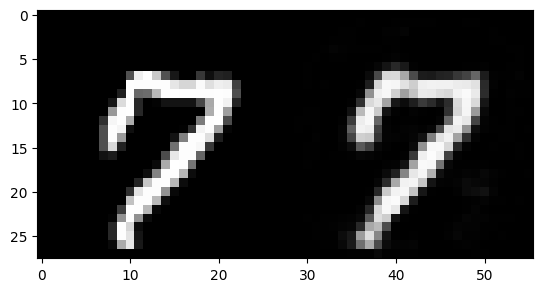

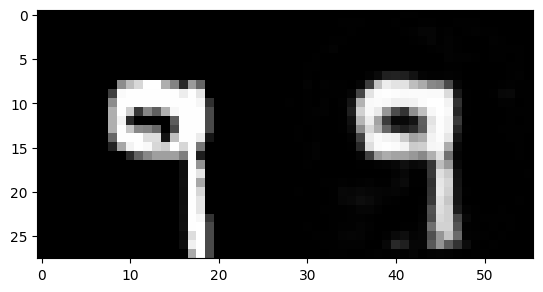

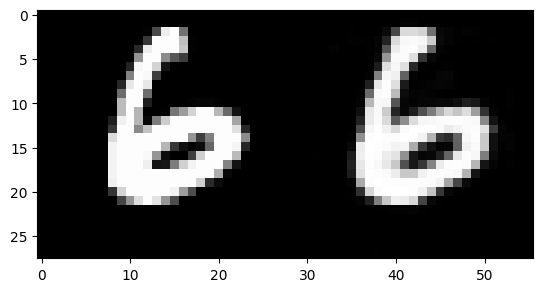

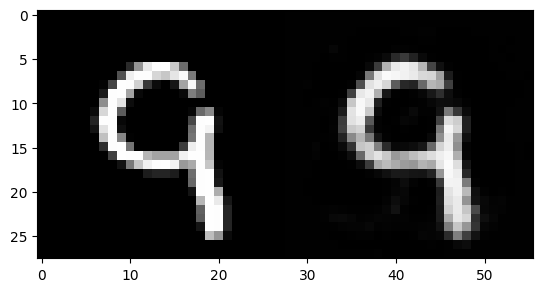

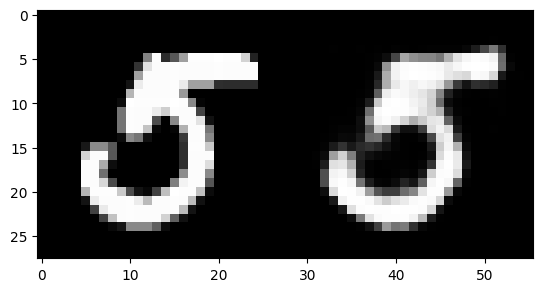

In [12]:
def reconstruct(model, test_loader, n=10):
    model.eval()
    with torch.no_grad():
        for images, _ in (test_loader):
            images = images.to(device)
            outputs = model(images)
            for i in range(n):
                img = images[i].view(28, 28).cpu().numpy()
                out = outputs[i].view(28, 28).cpu().numpy()
                plt.imshow(np.hstack([img, out]), cmap='gray')
                plt.show()
            break
        
reconstruct(model, test_loader, n = 10)